In [1]:
import os
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

from recs.utils.path import *
from recs.utils.common import readjson2dict, id2cat, save_model, save2json, recall_evaluate
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

In [2]:
def min_max(x):
    return pd.Series(index=['min', 'max'], data=[x.min(), x.max()])

def normalized(x):
    return (x - x.mean()) / x.std()

def embedding(values, method, n_components, **kwargs):
    dr_methods = {
        "pca": PCA,
        "tsne": TSNE,
    }
    
    if method not in dr_methods:
        raise ValueError("Supported dimensionality reduction: {}".format(dr_methods.keys()))
    
    if method == 'pca':
        x_embedded = dr_methods[method](n_components=n_components).fit_transform(values)
    
    if method == 'tsne':
        x_embedded = dr_methods[method](
            n_components=n_components, 
            init='random', 
            random_state= kwargs['random_state'],
            n_jobs= kwargs['n_jobs']
        ).fit_transform(values)
        x_embedded = np.array(x_embedded)
    return x_embedded

def load_value():
    print()

In [3]:
user_data = pd.read_pickle(DATA_PATH / "crm_diff.pkl")
user_data = user_data[user_data.yyyymm == 202012]
user_data.reset_index(drop=True, inplace=True)
print(user_data.columns)
user_data.apply(min_max)

Index(['yyyymm', 'id_number', 'local_foreign_total', 'local_total',
       'local_demand_deposit', 'local_fixed_deposit', 'foreign_total',
       'foreign_fixed_deposit', 'foreign_demand_deposit', 'invest_type', 'age',
       'monthly_trade_vol', 'stock_inventory_val', 'KPI',
       'local_foreign_total_diff', 'local_total_diff',
       'local_demand_deposit_diff', 'local_fixed_deposit_diff',
       'foreign_total_diff', 'foreign_fixed_deposit_diff',
       'foreign_demand_deposit_diff', 'monthly_trade_vol_diff',
       'stock_inventory_val_diff', 'local_foreign_total_pct',
       'local_total_pct', 'local_demand_deposit_pct',
       'local_fixed_deposit_pct', 'foreign_total_pct',
       'foreign_fixed_deposit_pct', 'foreign_demand_deposit_pct',
       'monthly_trade_vol_pct', 'stock_inventory_val_pct', 'age_group'],
      dtype='object')


yyyymm  id_number  local_foreign_total  local_total  \
min  202012          0             0.000000     0.000000   
max  202012      79847            20.417583    20.227482   

     local_demand_deposit  local_fixed_deposit  foreign_total  \
min              0.000000             0.000000        0.00000   
max             19.694073            19.344139       18.88741   

     foreign_fixed_deposit  foreign_demand_deposit  invest_type  ...  \
min               0.000000                0.000000            0  ...   
max              18.870456               18.785484            6  ...   

     local_foreign_total_pct  local_total_pct  local_demand_deposit_pct  \
min                     -inf             -inf                      -inf   
max                      1.0              1.0                       1.0   

     local_fixed_deposit_pct  foreign_total_pct  foreign_fixed_deposit_pct  \
min                     -inf               -inf                       -inf   
max                      1.0                1.0                        1.0   

     foreign_demand_deposit_pct  monthly_trade_vol_pct  \
min                        -inf                   -inf   
max                         1.0                    1.0   

     stock_inventory_val_pct  age_group  
min                     -inf          0  
max                      1.0         10  

[2 rows x 33 columns]

In [5]:
udata = user_data[['local_foreign_total', 'local_total',
       'local_demand_deposit', 'local_fixed_deposit', 'foreign_total',
       'foreign_fixed_deposit', 'foreign_demand_deposit', 'invest_type', 'age',
       'monthly_trade_vol', 'stock_inventory_val', 'KPI','local_foreign_total_diff', 'local_total_diff',
       'local_demand_deposit_diff', 'local_fixed_deposit_diff',
       'foreign_total_diff', 'foreign_fixed_deposit_diff',
       'foreign_demand_deposit_diff', 'monthly_trade_vol_diff',
       'stock_inventory_val_diff', 'local_foreign_total_pct',
       'local_total_pct', 'local_demand_deposit_pct',
       'local_fixed_deposit_pct', 'foreign_total_pct',
       'foreign_fixed_deposit_pct', 'foreign_demand_deposit_pct',
       'monthly_trade_vol_pct', 'stock_inventory_val_pct', 'age_group']] 
for i in ['local_foreign_total_diff', 'local_total_diff',
       'local_demand_deposit_diff', 'local_fixed_deposit_diff',
       'foreign_total_diff', 'foreign_fixed_deposit_diff',
       'foreign_demand_deposit_diff', 'monthly_trade_vol_diff',
       'stock_inventory_val_diff', 'local_foreign_total_pct',
       'local_total_pct', 'local_demand_deposit_pct',
       'local_fixed_deposit_pct', 'foreign_total_pct',
       'foreign_fixed_deposit_pct', 'foreign_demand_deposit_pct',
       'monthly_trade_vol_pct', 'stock_inventory_val_pct']:
    udata[i] = normalized(udata[i])
udata = udata.replace(-np.inf, -1)
udata.fillna(0, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
tran_user = user_data[user_data['id_number'].isin(tran_data["id_number"])].index.tolist()
non_tran_user = user_data[~user_data['id_number'].isin(tran_data["id_number"])].index.tolist()
udata.iloc[tran_user]

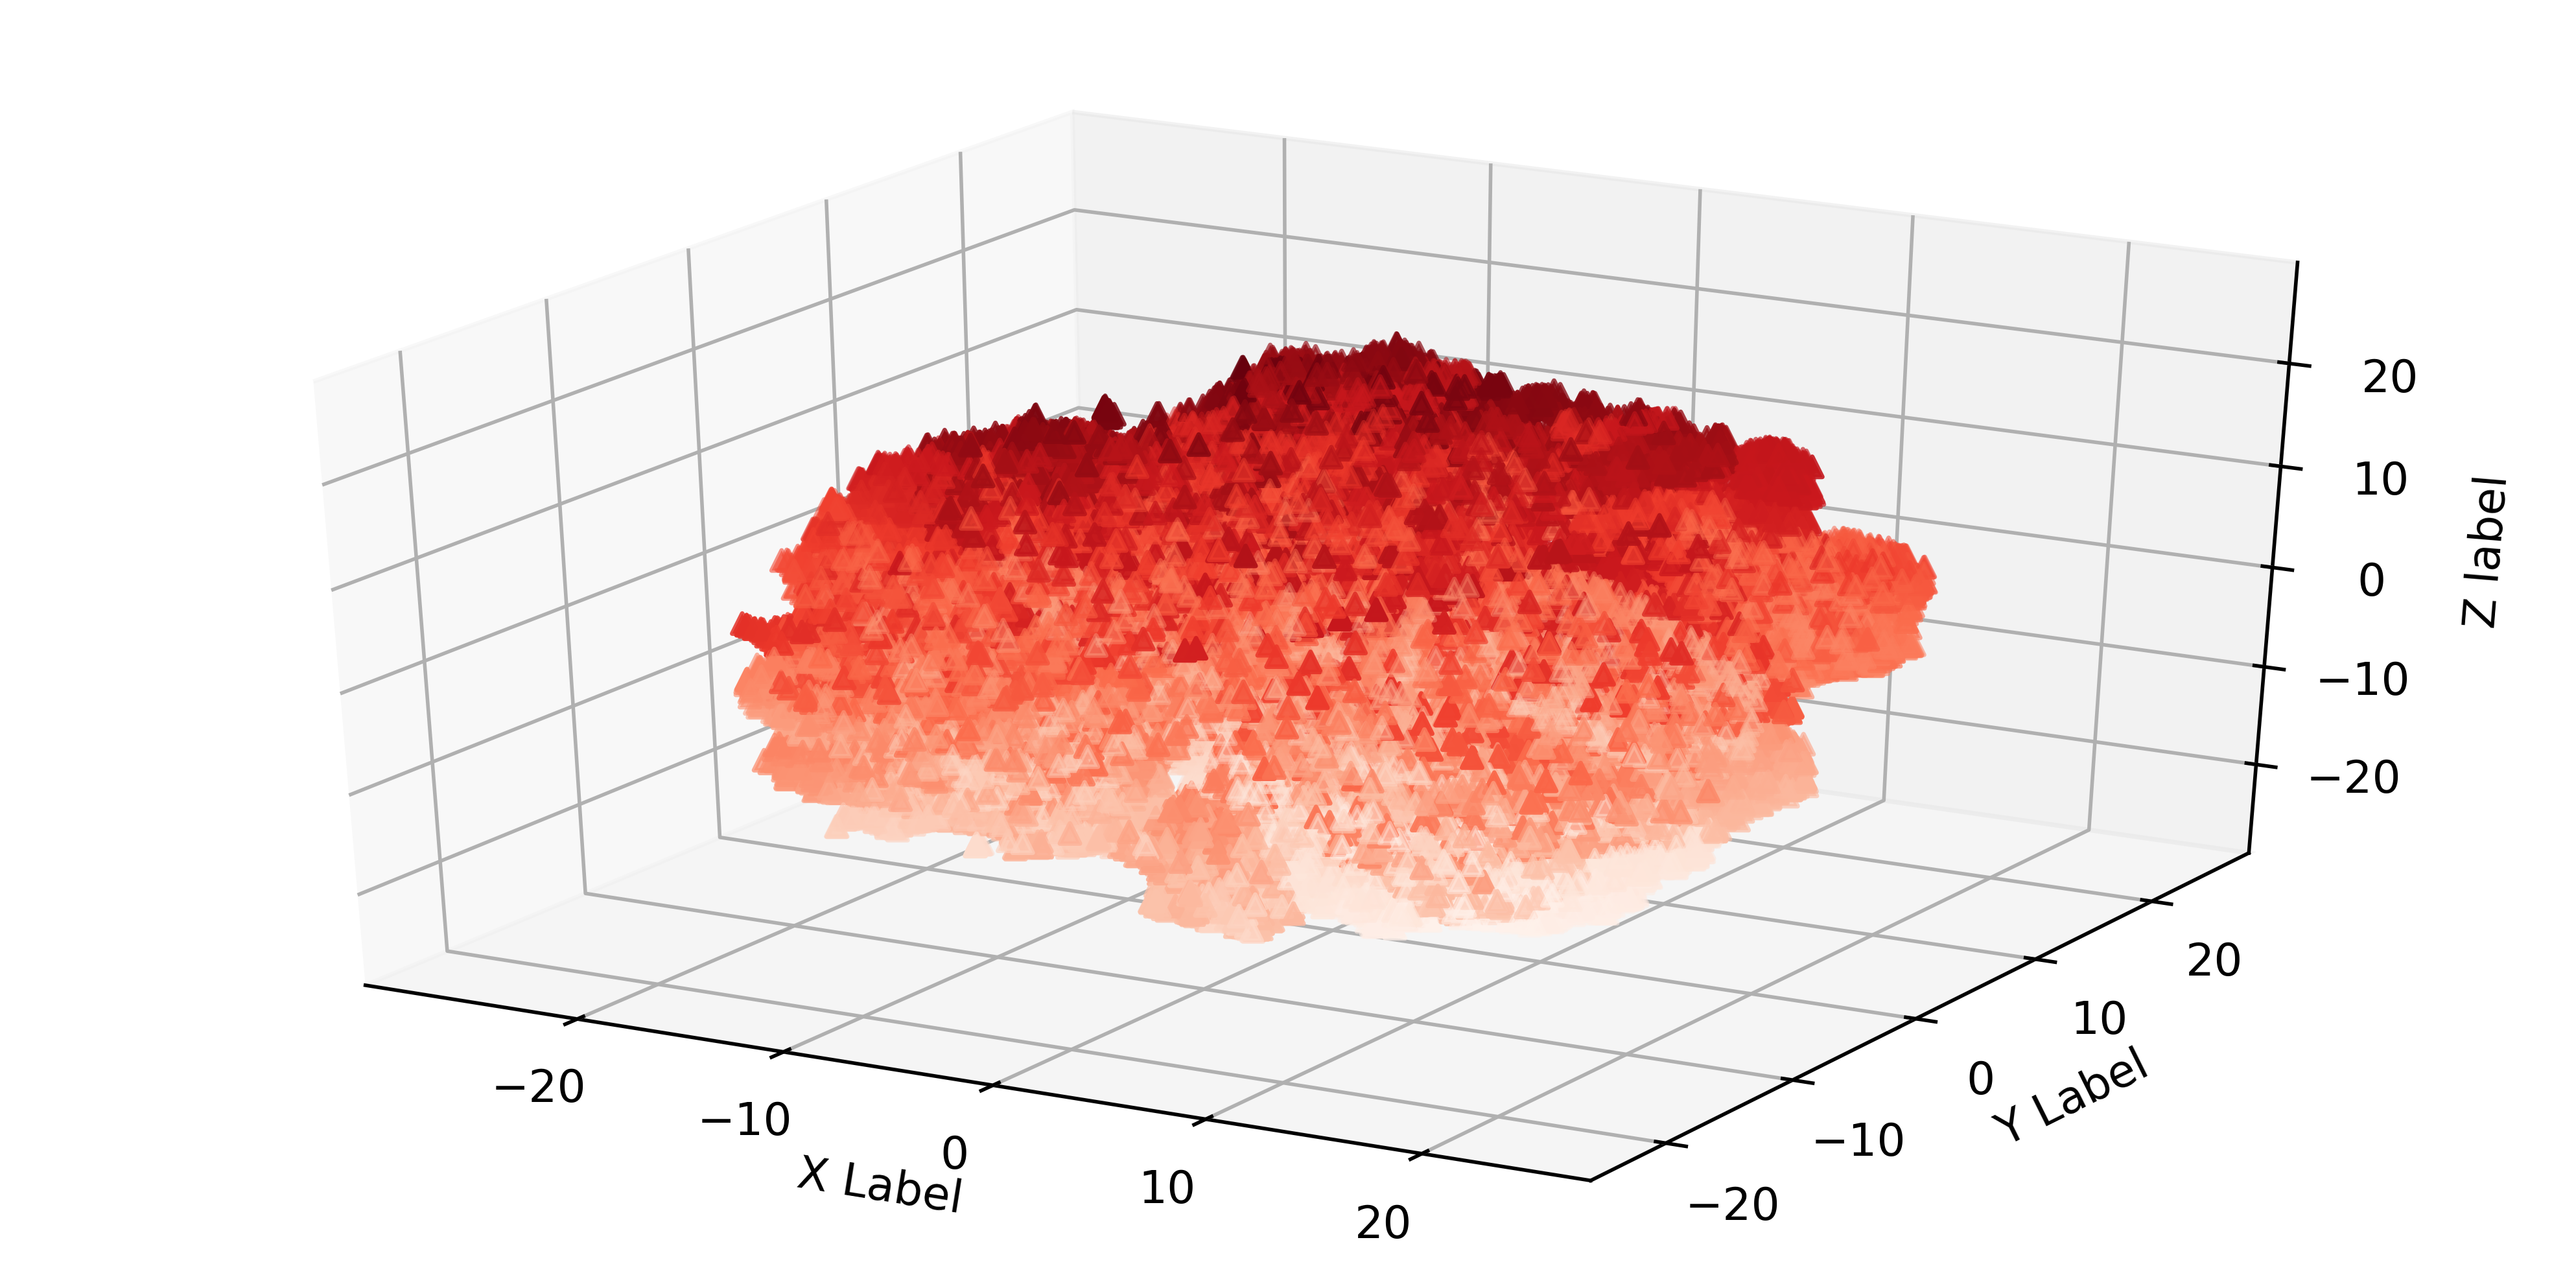

In [7]:
x_embedded = TSNE(n_components=3, init='random', random_state=47, n_jobs=30).fit_transform(udata.values)
x_embedded = np.array(x_embedded)
x = x_embedded[:, 0]
y = x_embedded[:, 1]
z = x_embedded[:, 2]
fig = plt.figure(figsize=(10, 5), dpi=500)
ax = fig.gca(projection='3d')
ax.scatter(x, y, z, c=z, cmap='Reds', marker='^')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z label')
plt.show()

In [ ]:

print(udata.values.shape)
x_embedded = PCA(n_components=2).fit_transform(udata.values)
x_embedded = np.array(x_embedded)
print(x_embedded.shape)
x = x_embedded[:, 0]
y = x_embedded[:, 1]
fig = plt.figure(figsize=(10, 5), dpi=500)
plt.scatter(x, y, marker='^', cmap='Reds')
plt.show()

In [ ]:
x_embedded = TSNE(n_components=2, init='random', random_state=47, n_jobs=30).fit_transform(udata.values)
x_embedded = np.array(x_embedded)
x = x_embedded[:, 0]
y = x_embedded[:, 1]
fig = plt.figure(figsize=(10, 5), dpi=500)
plt.scatter(x, y, marker='^', color='red')
plt.show()

In [ ]:
tran_x_embedded = x_embedded[tran_user]
t_x = tran_x_embedded[:, 0]
t_y = tran_x_embedded[:, 1]
nontran_x_embedded = x_embedded[non_tran_user]
nt_x = nontran_x_embedded[:, 0]
nt_y = nontran_x_embedded[:, 1]
fig = plt.figure(figsize=(10, 5), dpi=500)

plt.scatter(t_x, t_y, marker='^', color='blue')
plt.scatter(nt_x, nt_y, marker='^', color='red')

plt.show()

In [ ]:
tran_x_embedded = x_embedded[tran_user]
nontran_x_embedded = x_embedded[non_tran_user]

print(len(tran_x_embedded))
print(len(nontran_x_embedded))
t_x = tran_x_embedded[:, 0]
t_y = tran_x_embedded[:, 1]
t_z = tran_x_embedded[:, 2]
nt_x = nontran_x_embedded[:, 0]
nt_y = nontran_x_embedded[:, 1]
nt_z = nontran_x_embedded[:, 2]

fig = plt.figure(figsize=(10, 5), dpi=500)
ax = fig.gca(projection='3d')


ax.scatter(nt_x, nt_y, nt_z, c=nt_z, cmap='Reds', marker='^')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z label')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 5), dpi=500)
ax = fig.gca(projection='3d')

ax.scatter(t_x, t_y, t_z, c=t_z, cmap='Blues', marker='^')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z label')
plt.show()

In [ ]:
from sklearn.cluster import Birch
import itertools
brc = Birch(n_clusters=10)
brc.fit(x_embedded)
brc_x = np.array(brc.predict(x_embedded))

fig = plt.figure(figsize=(10, 5), dpi=500)

CMAPS= ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd']

cluster_result = {}
for i in range(10):
    indexes = np.where(brc_x ==i)[0]
    x_g = []
    y_g = []
    
    for j in indexes:
        x_g.append(x_embedded[j][0])
        y_g.append(x_embedded[j][1])
    plt.scatter(x_g, y_g, c=x_g, marker='^', cmap=CMAPS[i])
    
plt.show()

In [ ]:
indexes = np.where(brc_x ==0)[0]
print(len(indexes))

In [ ]:
x_embedded.shape

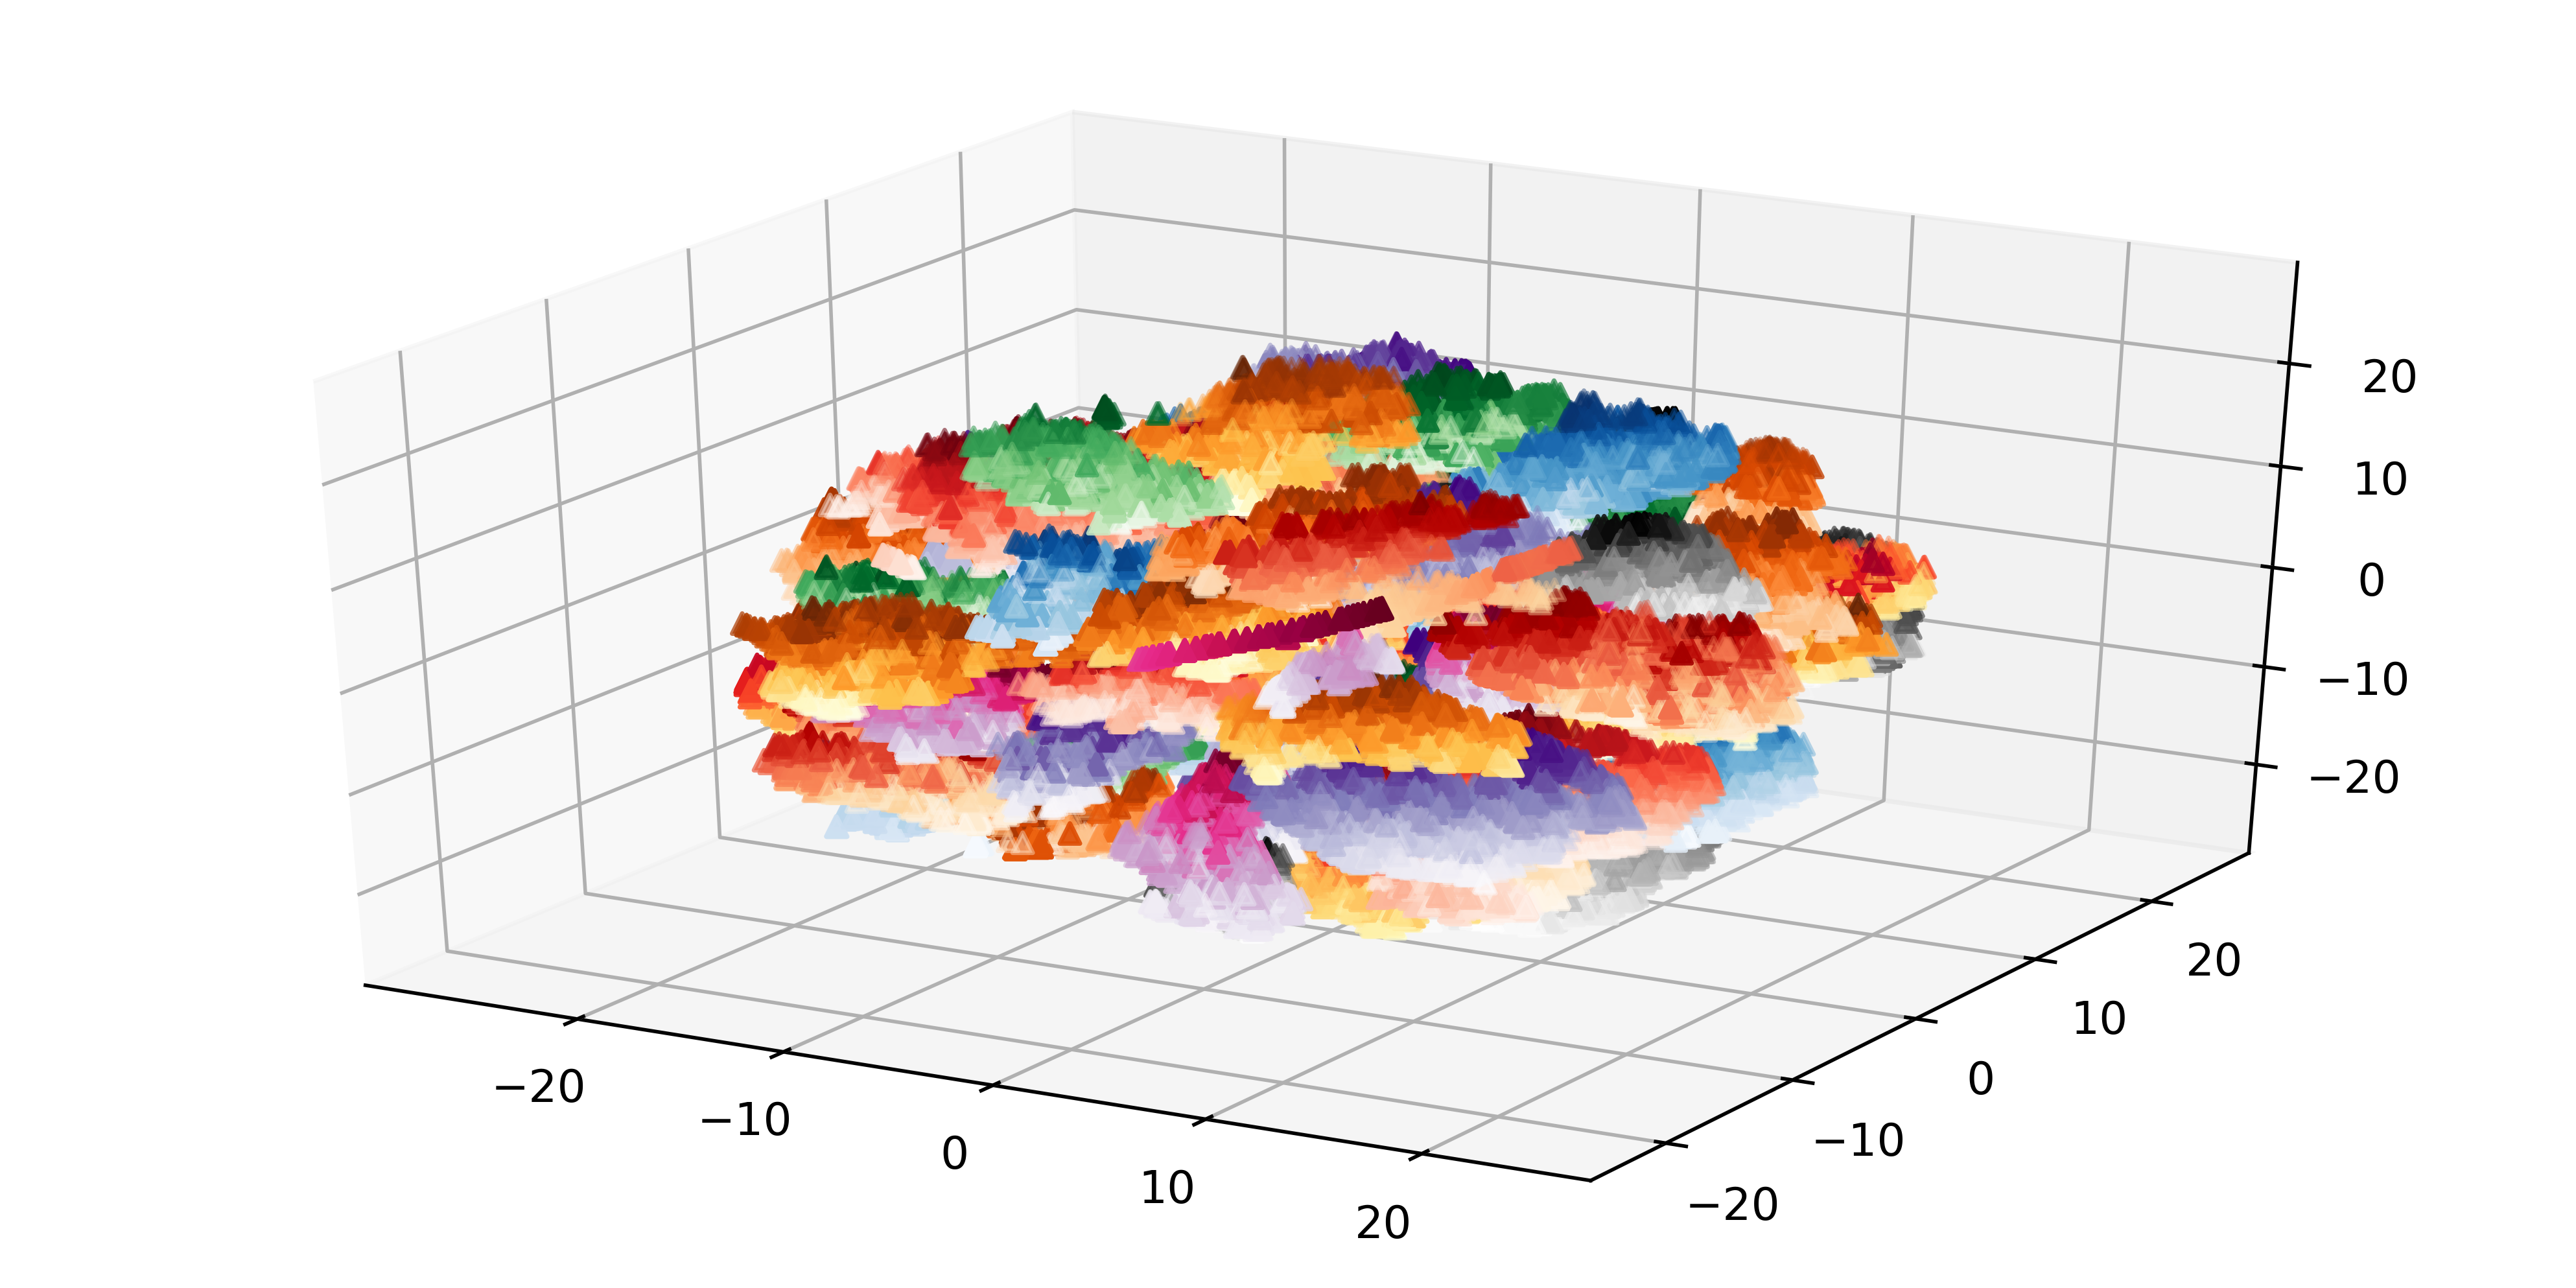

In [8]:
from sklearn.cluster import Birch
import itertools
n_cluster = 100
brc = Birch(n_clusters=n_cluster)
brc.fit(x_embedded)
brc_x = np.array(brc.predict(x_embedded))

fig = plt.figure(figsize=(10, 5), dpi=500)
ax = fig.gca(projection='3d')

CMAPS= itertools.cycle(['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd'])

cluster_result = {}
for i in range(n_cluster):
    indexes = np.where(brc_x ==i)[0]
    x_g = []
    y_g = []
    z_g = []
    for j in indexes:
        x_g.append(x_embedded[j][0])
        y_g.append(x_embedded[j][1])
        z_g.append(x_embedded[j][2])
    ax.scatter(x_g, y_g, z_g, c=z_g, cmap=next(CMAPS), marker='^', label=f"G{i}")
    
plt.show()

In [16]:
tran_data = pd.read_pickle(DATA_PATH / "trans_buy.pkl")
user_data['cluster'] = brc_x
cluster_rec = {}

best_sells = tran_data[
    (tran_data.buy_date > 20171200 )
].fund_id.value_counts().rename_axis('fund_id').reset_index(name='count')['fund_id'].tolist()[:10]


for i in tqdm(range(n_cluster)):
    userlen = len(user_data[user_data['cluster'] == i])
    tranlen = len(tran_data[tran_data['id_number'].isin( user_data[user_data['cluster'] == i]['id_number'])])
    temp = tran_data[tran_data['id_number'].isin( user_data[user_data['cluster'] == i]['id_number'])]['fund_id'].value_counts().index.tolist()[:10]
    if len(temp) < 10:
        cluster_rec[i] = best_sells
    else:
        cluster_rec[i] = temp
    

100%|██████████| 100/100 [00:01<00:00, 78.49it/s]


In [17]:
cluster_rec_dict = {}
target_users = user_data.id_number.tolist()
for u in tqdm(target_users):
    temp = user_data[user_data['id_number']==u]
    t_cluster = temp.cluster.tolist()[0]    
    cluster_rec_dict[u] = cluster_rec[t_cluster]

        
    

100%|██████████| 79848/79848 [00:42<00:00, 1881.68it/s]


In [ ]:
tran_data = pd.read_pickle(DATA_PATH / "trans_buy.pkl")
result_analysis = {
    "cluster":[],
    "user_num":[],
    "item_num":[],
    "tran_num":[],
    "items":[],
    
}
for i in range(n_cluster):
    userlen = len(user_data[user_data['cluster'] == i])
    tranlen = len(tran_data[tran_data['id_number'].isin( user_data[user_data['cluster'] == i]['id_number'])])
    temp = tran_data[tran_data['id_number'].isin( user_data[user_data['cluster'] == i]['id_number'])]['fund_id'].value_counts().index.tolist()[:10]
    result_analysis["cluster"].append(i)
    result_analysis["user_num"].append(userlen)
    result_analysis["item_num"].append(len(temp))
    result_analysis["items"].append(temp)
    result_analysis["tran_num"].append(tranlen)
    
#     print(i, userlen ,len(temp), temp)
ra = pd.DataFrame(result_analysis)
ra

In [ ]:
ra.sort_values(by='tran_num')

In [13]:
from recs.utils.common import id2cat
from tqdm import tqdm
tqdm.pandas()
u2idx = readjson2dict("crm_idx")
i2idx = readjson2dict("fund_info_idx")

In [ ]:
decode_user_data = user_data.copy()
decode_user_data['id_number'] = decode_user_data['id_number'].progress_apply(lambda x: id2cat(u2idx, x))

In [ ]:
vaecf_data

In [ ]:
vaecf_data = pd.read_csv(DATA_PATH / "r_vaecf_tw.csv")
result_analysis["vaecf"] = []
cluster_rec = {}
for i in range(n_cluster):
    count_dict = {}

    temp = vaecf_data[vaecf_data['uid'].isin(decode_user_data[decode_user_data['cluster'] == i]['id_number'])]

    for j in range(10):
        temp_count_dict = temp[f"fundid{j}"].value_counts().to_dict()
        for k in temp_count_dict.keys():
            if count_dict.get(k):
                count_dict[k] += int(temp_count_dict[k])
            else:
                count_dict[k] = int(temp_count_dict[k])


    result = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))    
    cluster_rec[i] = list(result.keys())[0:10]
    result_analysis["vaecf"].append(list(result.keys())[0:10])
cluster_rec

In [ ]:
ra = pd.DataFrame(result_analysis)
ra.columns
ra[['cluster', 'user_num', 'item_num', 'tran_num', 'vaecf']]

In [ ]:
udict = {
    "uid":[], "fundid0":[], "fundid1":[], "fundid2":[], "fundid3":[], "fundid4":[], "fundid5":[], "fundid6":[], "fundid7":[], "fundid8":[], "fundid9":[]
}
for idx, urow in tqdm(decode_user_data.iterrows()):
    udict["uid"].append(urow['id_number'])
    u_rec = cluster_rec[urow['cluster']]
    for i in range(10):        
        udict[f"fundid{i}"].append(u_rec[i])

    

In [ ]:
pd.DataFrame(udict).to_csv("r_2022_04_04_cluster100_vae.csv", index=False)

In [ ]:



count_dict = {}

for i in temp_count_dict.keys():
    if count_dict.get(i):
        count_dict += temp_count_dict[i]
    else:
        count_dict[i] = temp_count_dict[i]

In [ ]:
count_dict

In [ ]:
 user_data[user_data['cluster'] == 99]

In [ ]:
len(user_data.id_number.unique())

In [ ]:
len(tran_data.id_number.unique())

In [ ]:
non_tran = list(set(user_data.id_number.unique().tolist()) - set(tran_data.id_number.unique().tolist()))

In [ ]:
len(non_tran)

In [18]:
rec_result = {}

for user in tqdm(cluster_rec_dict):
    dec_user = id2cat(u2idx, int(user))
    dec_funds = []
    for item in cluster_rec_dict[user]:
        dec_funds.append(id2cat(i2idx, item))
    rec_result[dec_user] = dec_funds

    import json
from recs.utils.common import convert_result_json_2_csv
r_name = "r_2022_04_06_cbestsell"
json_name = r_name+".json"
json_save_path = RESULT_PATH / json_name 
with open(json_save_path, 'w') as jf:
    json.dump(rec_result, jf)

csv_name = f"{r_name}.csv"
save_path = RESULT_PATH / csv_name
convert_result_json_2_csv(str(json_save_path), str(save_path))

100%|██████████| 79848/79848 [04:58<00:00, 267.30it/s]


Convert ../../result/r_2022_04_06_cbestsell.json to ../../result/r_2022_04_06_cbestsell.csv success.


In [19]:
pd.read_csv(save_path)

Unnamed: 0          uid fundid0 fundid1 fundid2 fundid3 fundid4  \
0               0  H2799640320     T34     Y38     T38     V09     L0C   
1               1  A2721045170     Y38     T34     V09     MU7     J1N   
2               2  S2224147000     T34     T38     76T     78X     Y57   
3               3  P2773542580     T34     Y57     T38     L17     MB0   
4               4  H1796560940     T34     TT1     MX5     L91     H37   
...           ...          ...     ...     ...     ...     ...     ...   
79843       79843  F1726210120     T34     L91     MB0     Y57     MX5   
79844       79844  H1702051390     T34     T38     Y38     MX5     Y57   
79845       79845  H1759464790     MB0     T34     MX5     J1N     UN8   
79846       79846  Q2754829780     T34     MX5     MB0     J1N     T38   
79847       79847  A2422411050     MB0     X01     T38     J80     GK4   

      fundid5 fundid6 fundid7 fundid8 fundid9  
0         J1N     MB0     L17     J84     MU7  
1         X01     MX5     MB0     T38     L91  
2         86G     L91     J99     88P     68C  
3         Y38     UN8     MX5     MU7     TT1  
4         Y38     J1N     L0C     L17     UN8  
...       ...     ...     ...     ...     ...  
79843     T38     J1N     L0C     Y38     L17  
79844     J1N     L17     L91     MU7     317  
79845     Y37     MU7     L91     Y38     MU5  
79846     Y57     TT1     Y38     Y37     L17  
79847     MX5     CZ6     L17     UN8     J1N  

[79848 rows x 12 columns]